In [1]:
# Load packages and check versions
import sys
import numpy as np
import pandas as pd
import scipy
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 400 #high res figures
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
import xgboost as xgb
import shap
import pickle

print('The Python version is {}.\n'.format(sys.version))
print('The Numpy version is {}.\n'.format(np.__version__))
print('The Pandas version is {}.\n'.format(pd.__version__))
print('The Scipy version is {}.\n'.format(scipy.__version__))
print('The Matplotlib version is {}.\n'.format(mpl.__version__))
print('The Scikit-Learn version is {}.\n'.format(sklearn.__version__))
print('The XGBoost version is {}.\n'.format(xgb.__version__))
print('The SHAP version is {}.\n'.format(shap.__version__))
# The Python version is 3.8.2 (default, Mar 26 2020, 10:43:30) 
# [Clang 4.0.1 (tags/RELEASE_401/final)].

# The Numpy version is 1.19.2.

# The Pandas version is 1.2.1.

# The Scipy version is 1.6.1.

# The Matplotlib version is 3.3.2.

# The Scikit-Learn version is 0.23.2.

# The XGBoost version is 1.3.0.

# The SHAP version is 0.37.0.

The Python version is 3.8.2 (default, Mar 26 2020, 10:43:30) 
[Clang 4.0.1 (tags/RELEASE_401/final)].

The Numpy version is 1.19.2.

The Pandas version is 1.2.1.

The Scipy version is 1.6.1.

The Matplotlib version is 3.3.2.

The Scikit-Learn version is 0.23.2.

The XGBoost version is 1.3.0.

The SHAP version is 0.37.0.



In [2]:
with open('../../Data/xgb_model_w_data.pkl', 'rb') as f:
    features_response, X_train_all, y_train_all, X_test_all,\
    y_test_all, xgb_model_4 = pickle.load(f)

# Model Predictions and Performance on Test Set

In [3]:
test_set_pred_proba = xgb_model_4.predict_proba(X_test_all)[:,1]

In [4]:
from sklearn.metrics import roc_auc_score
test_auc = roc_auc_score(y_test_all, test_set_pred_proba)
test_auc

0.7735528979671706

In [5]:
test_set_pred_proba.shape

(5938,)

Text(0, 0.5, 'Number of samples')

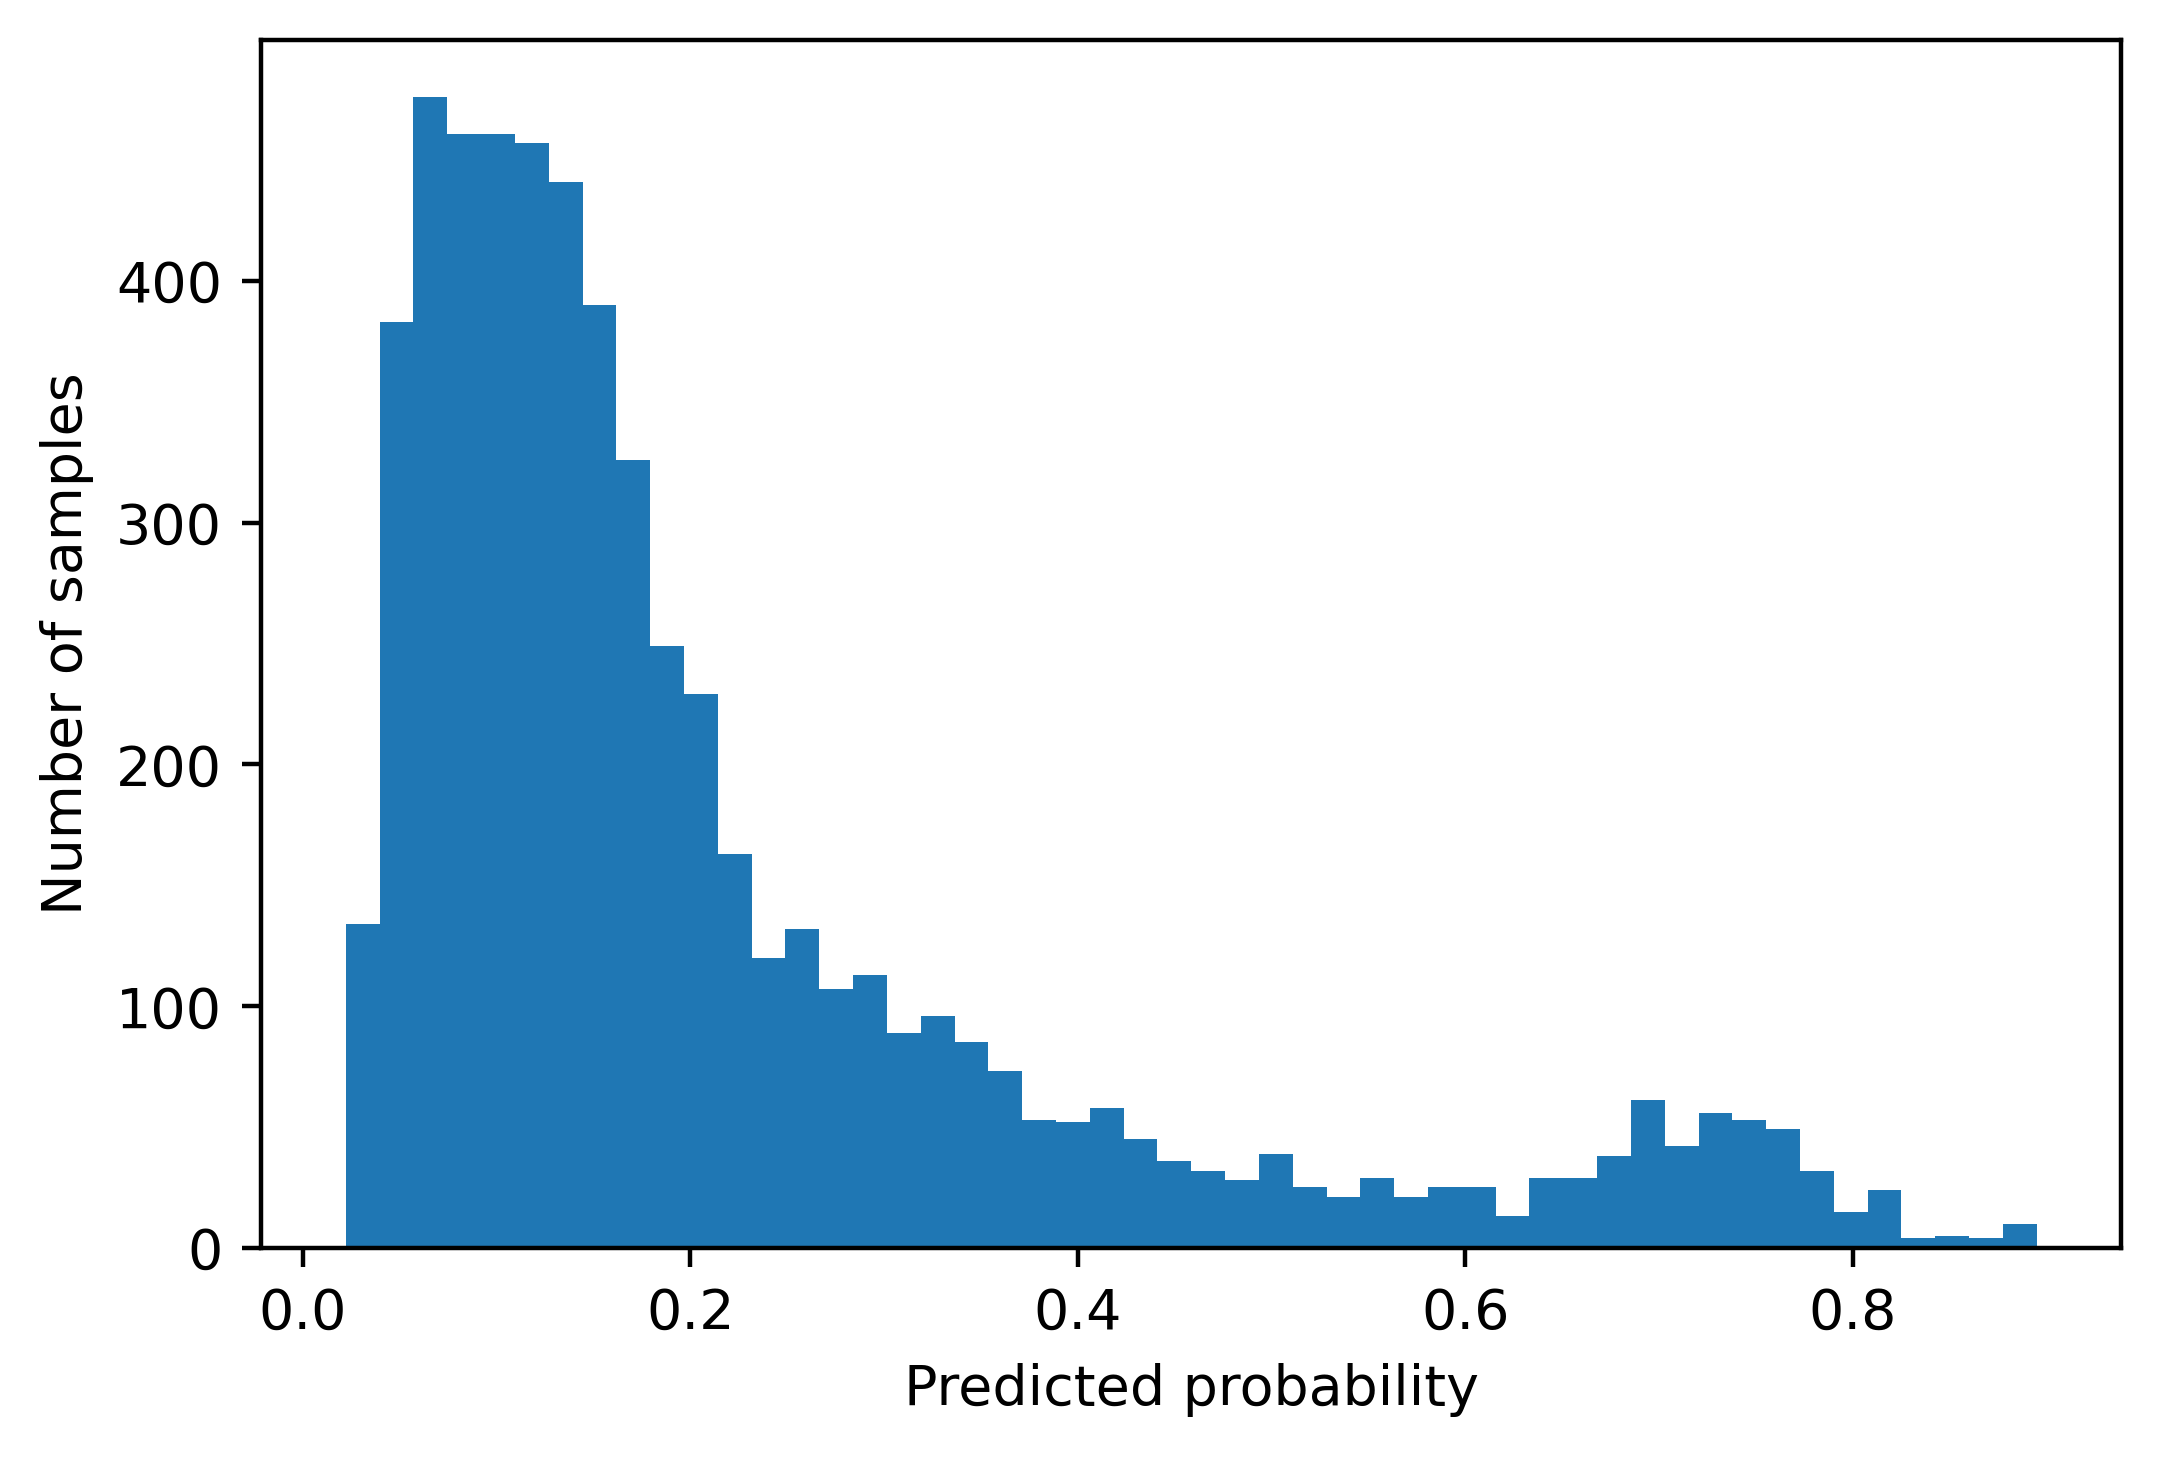

In [6]:
mpl.rcParams['figure.dpi'] = 400
plt.hist(test_set_pred_proba, bins=50)
plt.xlabel('Predicted probability')
plt.ylabel('Number of samples')

In [7]:
deciles, decile_bin_edges = pd.qcut(x=test_set_pred_proba,
                                    q=10,
                                    retbins=True)
# pandas.qcut(x, q, labels=None, retbins=False, precision=3, duplicates='raise')

In [8]:
decile_bin_edges

array([0.02213463, 0.06000734, 0.08155108, 0.10424594, 0.12708404,
       0.15019046, 0.18111563, 0.23032923, 0.32210371, 0.52585585,
       0.89491451])

In [9]:
test_set_df = pd.DataFrame({'Predicted probability':test_set_pred_proba,
                            'Prediction decile':deciles,
                            'Outcome':y_test_all})
test_set_df.head()

,Predicted probability,Prediction decile,Outcome
0,0.544556,"(0.526, 0.895]",0
1,0.621311,"(0.526, 0.895]",0
2,0.049883,"(0.0211, 0.06]",0
3,0.890924,"(0.526, 0.895]",1
4,0.272326,"(0.23, 0.322]",0


In [10]:
test_set_gr = test_set_df.groupby('Prediction decile')
gr_df = test_set_gr.agg({'Outcome':['count', 'mean']})

In [11]:
gr_df

Outcome          
                    count      mean
Prediction decile                  
(0.0211, 0.06]        594  0.045455
(0.06, 0.0816]        594  0.070707
(0.0816, 0.104]       594  0.099327
(0.104, 0.127]        593  0.112985
(0.127, 0.15]         594  0.116162
(0.15, 0.181]         594  0.171717
(0.181, 0.23]         593  0.195616
(0.23, 0.322]         594  0.282828
(0.322, 0.526]        594  0.392256
(0.526, 0.895]        594  0.676768

In [12]:
gr_df.columns

MultiIndex([('Outcome', 'count'),
            ('Outcome',  'mean')],
           )

In [13]:
gr_df[('Outcome', 'count')]

Prediction decile
(0.0211, 0.06]     594
(0.06, 0.0816]     594
(0.0816, 0.104]    594
(0.104, 0.127]     593
(0.127, 0.15]      594
(0.15, 0.181]      594
(0.181, 0.23]      593
(0.23, 0.322]      594
(0.322, 0.526]     594
(0.526, 0.895]     594
Name: (Outcome, count), dtype: int64

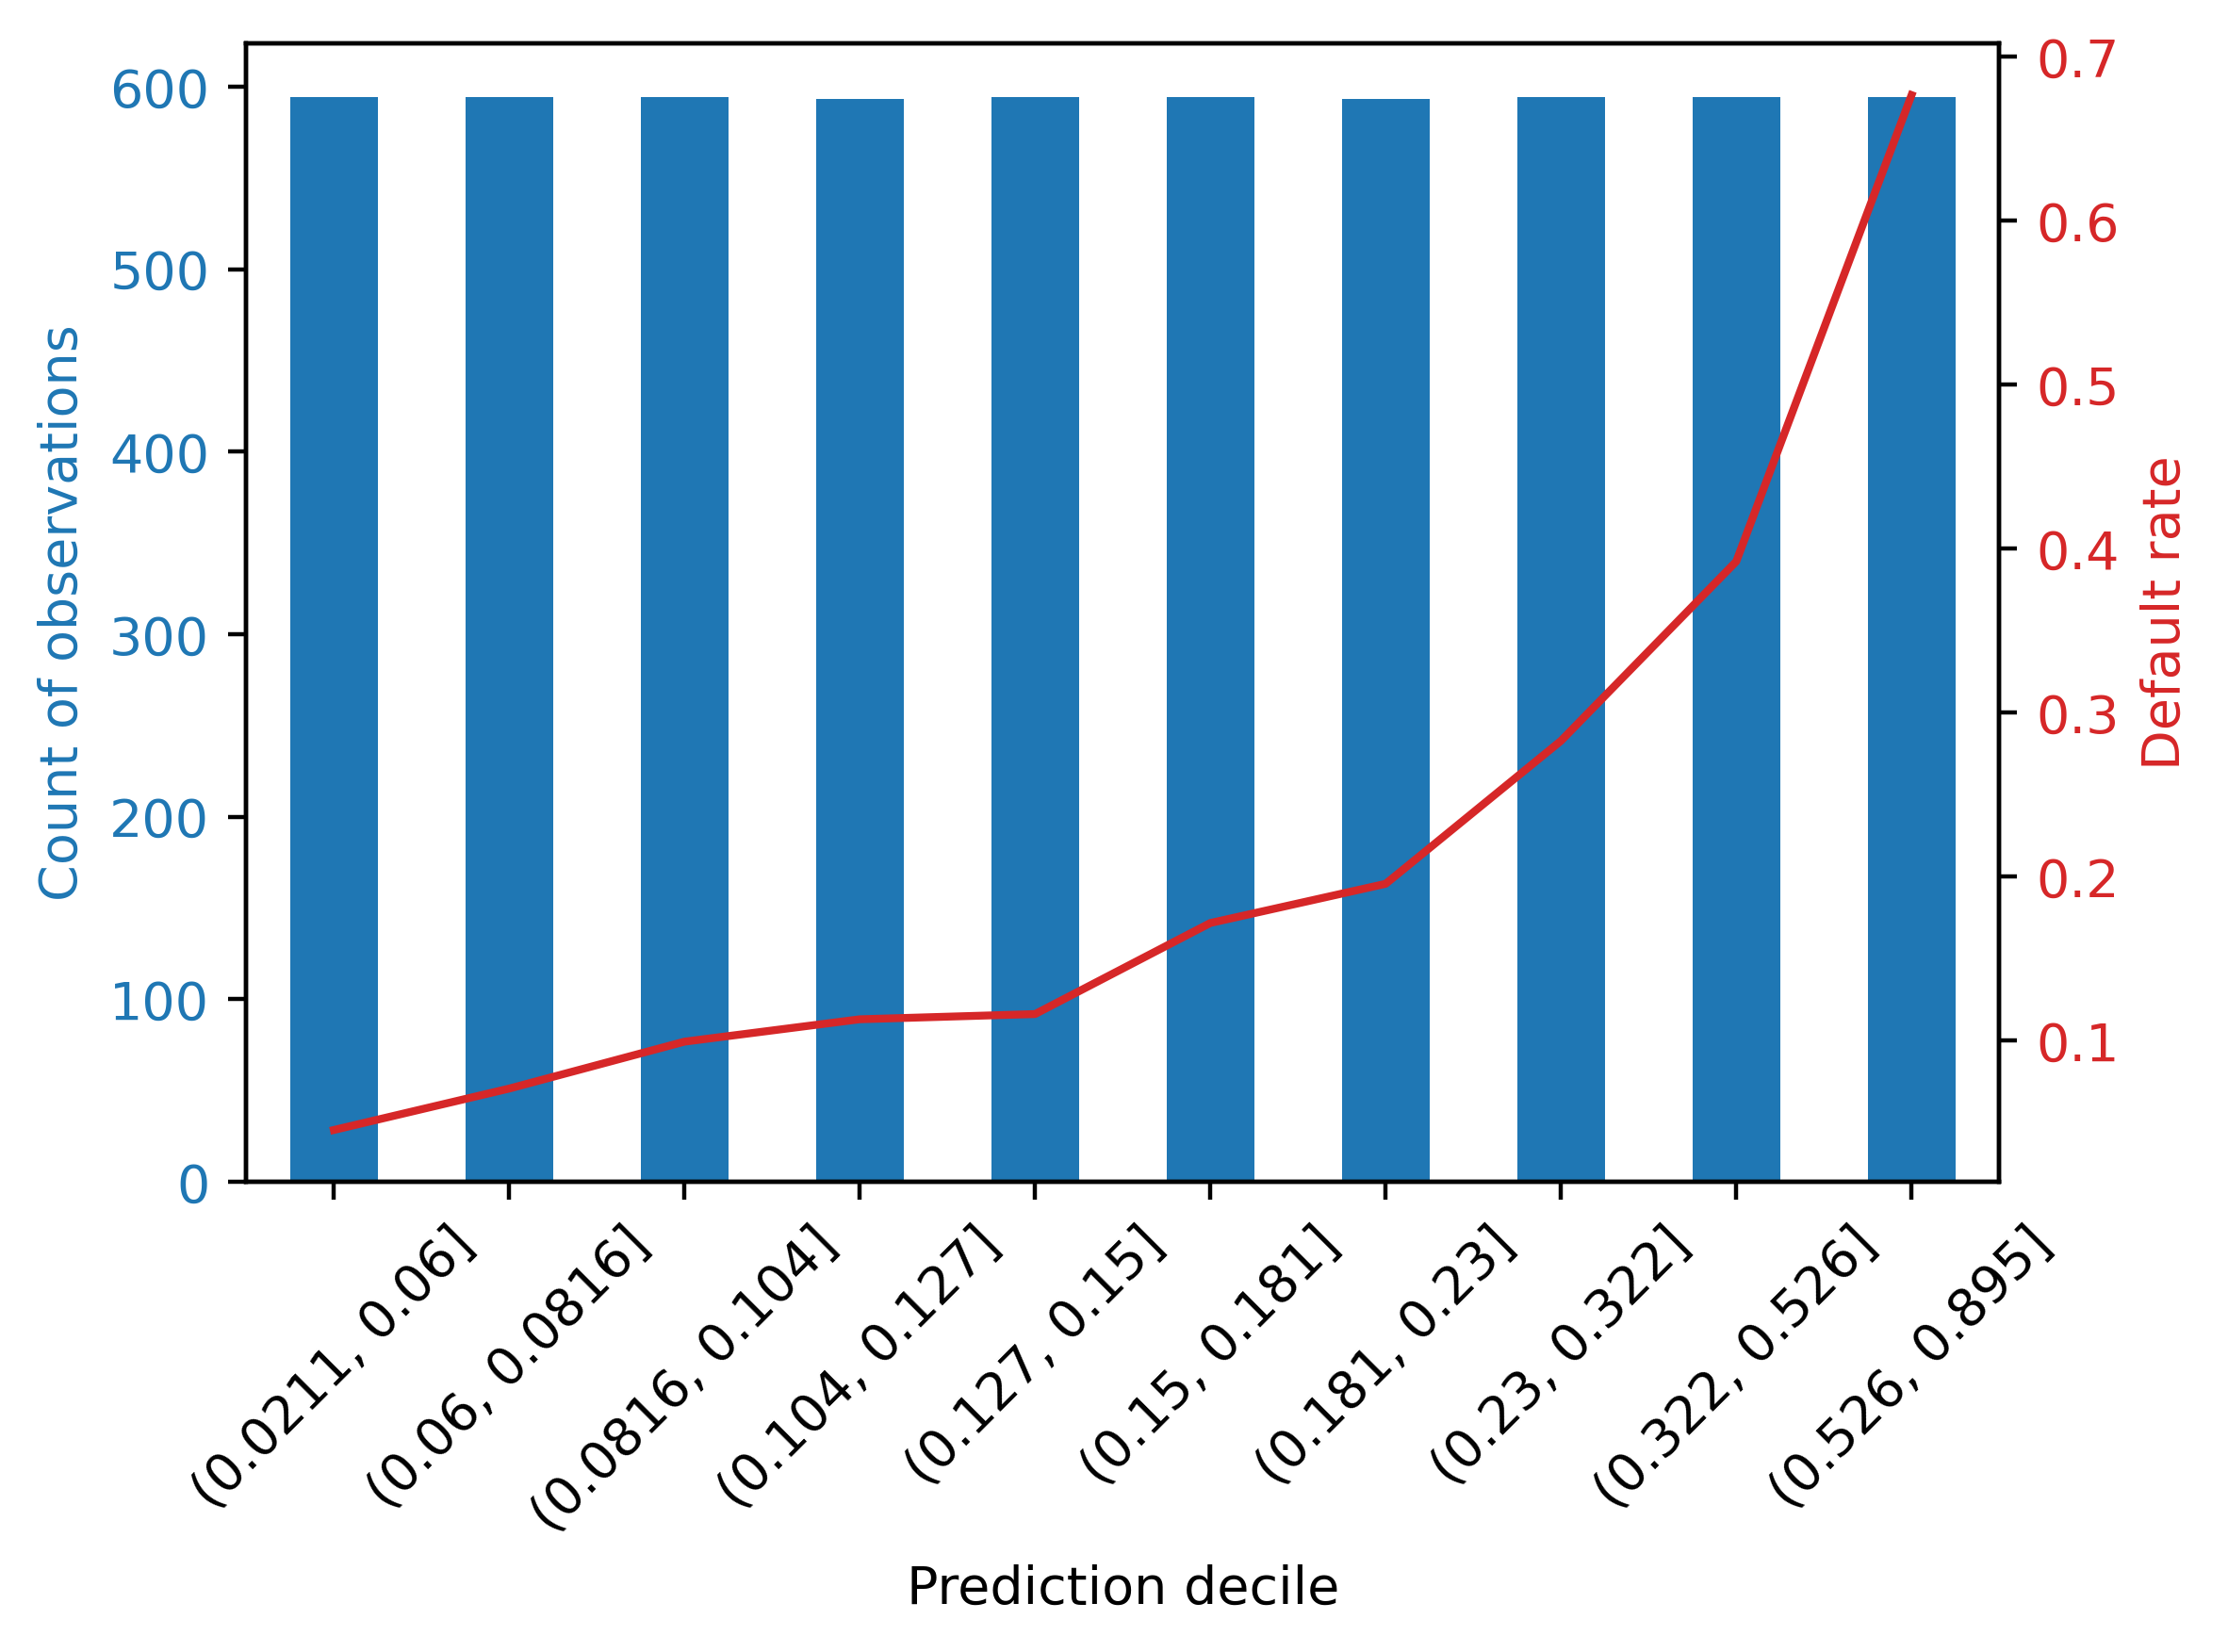

In [14]:
ax_1 = plt.axes()
color_1 = 'tab:blue'
gr_df[('Outcome', 'count')].plot.bar(ax=ax_1, color=color_1)
ax_1.set_ylabel('Count of observations', color=color_1)
ax_1.tick_params(axis='y', labelcolor=color_1)
ax_1.tick_params(axis='x', labelrotation = 45)

ax_2 = ax_1.twinx()
color_2 = 'tab:red'
gr_df[('Outcome', 'mean')].plot(ax=ax_2, color=color_2)
ax_2.set_ylabel('Default rate', color=color_2)
ax_2.tick_params(axis='y', labelcolor=color_2)

# Exercise 7.01: Equal Interval Chart

In [15]:
equal_intervals, equal_interval_bin_edges = \
    pd.cut(x=test_set_pred_proba,
           bins=5,
           retbins=True)
# pandas.qcut(x, q, labels=None, retbins=False, precision=3, duplicates='raise')

In [16]:
equal_interval_bin_edges

array([0.02126185, 0.1966906 , 0.37124658, 0.54580256, 0.72035853,
       0.89491451])

In [17]:
equal_interval_bin_edges[1:] - equal_interval_bin_edges[:-1]

array([0.17542876, 0.17455598, 0.17455598, 0.17455598, 0.17455598])

In [18]:
print(test_set_pred_proba.min())
print(test_set_pred_proba.max())

0.022134628
0.8949145


In [19]:
test_set_bins_df = pd.DataFrame({'Predicted probability':test_set_pred_proba,
                                 'Prediction bin':equal_intervals,
                                 'Outcome':y_test_all})
test_set_bins_df.head()

,Predicted probability,Prediction bin,Outcome
0,0.544556,"(0.371, 0.546]",0
1,0.621311,"(0.546, 0.72]",0
2,0.049883,"(0.0213, 0.197]",0
3,0.890924,"(0.72, 0.895]",1
4,0.272326,"(0.197, 0.371]",0


In [20]:
test_set_equal_gr = test_set_bins_df.groupby('Prediction bin')
gr_eq_df = test_set_equal_gr.agg({'Outcome':['count', 'mean']})

In [21]:
gr_eq_df

Outcome          
                  count      mean
Prediction bin                   
(0.0213, 0.197]    3778  0.108788
(0.197, 0.371]     1207  0.257664
(0.371, 0.546]      389  0.465296
(0.546, 0.72]       312  0.608974
(0.72, 0.895]       252  0.761905

In [22]:
p = gr_eq_df[('Outcome', 'mean')].values
n = gr_eq_df[('Outcome', 'count')].values
std_err = np.sqrt(p * (1-p) / n)
std_err

array([0.00506582, 0.01258848, 0.02528987, 0.02762643, 0.02683029])

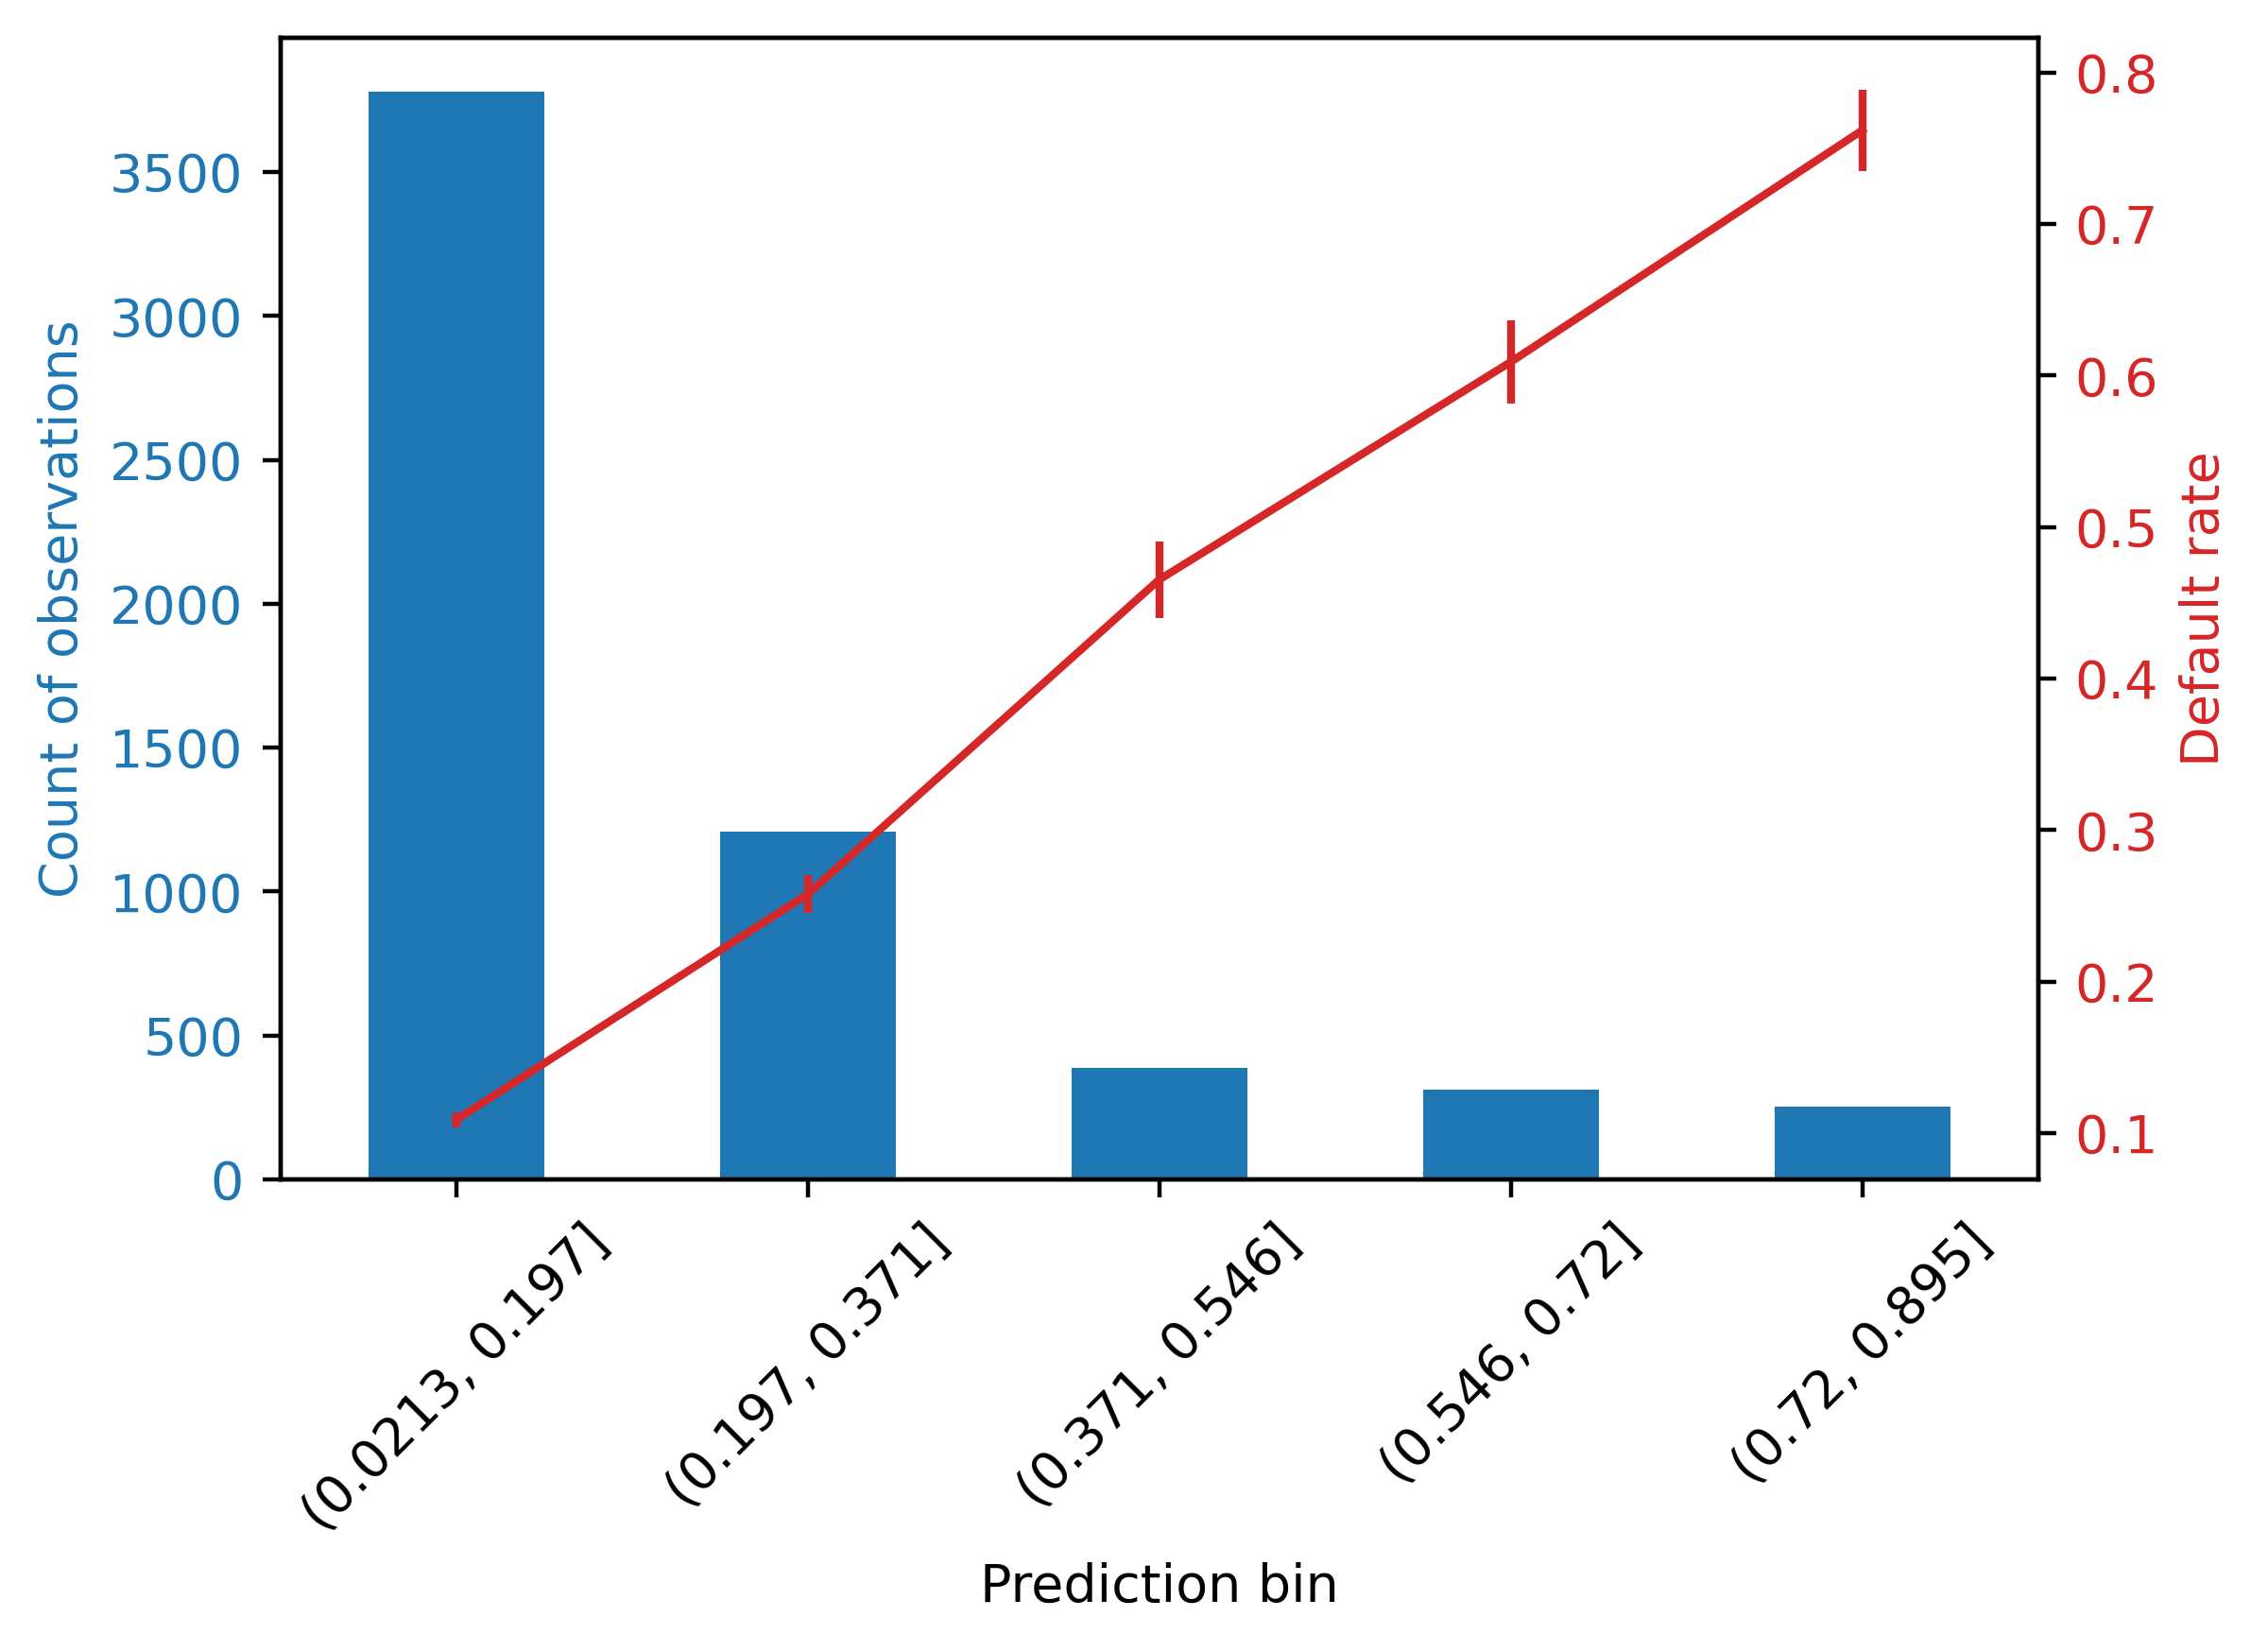

In [23]:
ax_1 = plt.axes()
color_1 = 'tab:blue'
gr_eq_df[('Outcome', 'count')].plot.bar(ax=ax_1, color=color_1)
ax_1.set_ylabel('Count of observations', color=color_1)
ax_1.tick_params(axis='y', labelcolor=color_1)
ax_1.tick_params(axis='x', labelrotation = 45)

ax_2 = ax_1.twinx()
color_2 = 'tab:red'
gr_eq_df[('Outcome', 'mean')].plot(ax=ax_2, color=color_2,
                                   yerr=std_err)
ax_2.set_ylabel('Default rate', color=color_2)
ax_2.tick_params(axis='y', labelcolor=color_2)

# Calibration

ECE metric https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4410090/

In [24]:
# sklearn.calibration.calibration_curve(y_true, y_prob, *, normalize=False, n_bins=5, strategy='uniform')

In [25]:
cal_df = test_set_gr.agg({'Outcome':['count', 'mean'],
                          'Predicted probability':'mean'})
cal_df

Outcome           Predicted probability
                    count      mean                  mean
Prediction decile                                        
(0.0211, 0.06]        594  0.045455              0.046931
(0.06, 0.0816]        594  0.070707              0.070745
(0.0816, 0.104]       594  0.099327              0.093163
(0.104, 0.127]        593  0.112985              0.115823
(0.127, 0.15]         594  0.116162              0.138657
(0.15, 0.181]         594  0.171717              0.165012
(0.181, 0.23]         593  0.195616              0.203106
(0.23, 0.322]         594  0.282828              0.273172
(0.322, 0.526]        594  0.392256              0.400159
(0.526, 0.895]        594  0.676768              0.693437

In [26]:
y_test_all.shape

(5938,)

In [27]:
F = cal_df[('Outcome', 'count')].values/y_test_all.shape[0]
F

array([0.10003368, 0.10003368, 0.10003368, 0.09986527, 0.10003368,
       0.10003368, 0.09986527, 0.10003368, 0.10003368, 0.10003368])

In [28]:
ECE = np.sum(
    F
    * np.abs(
             cal_df[('Outcome', 'mean')]
             - cal_df[('Predicted probability', 'mean')]))
ECE

0.008144502190176022

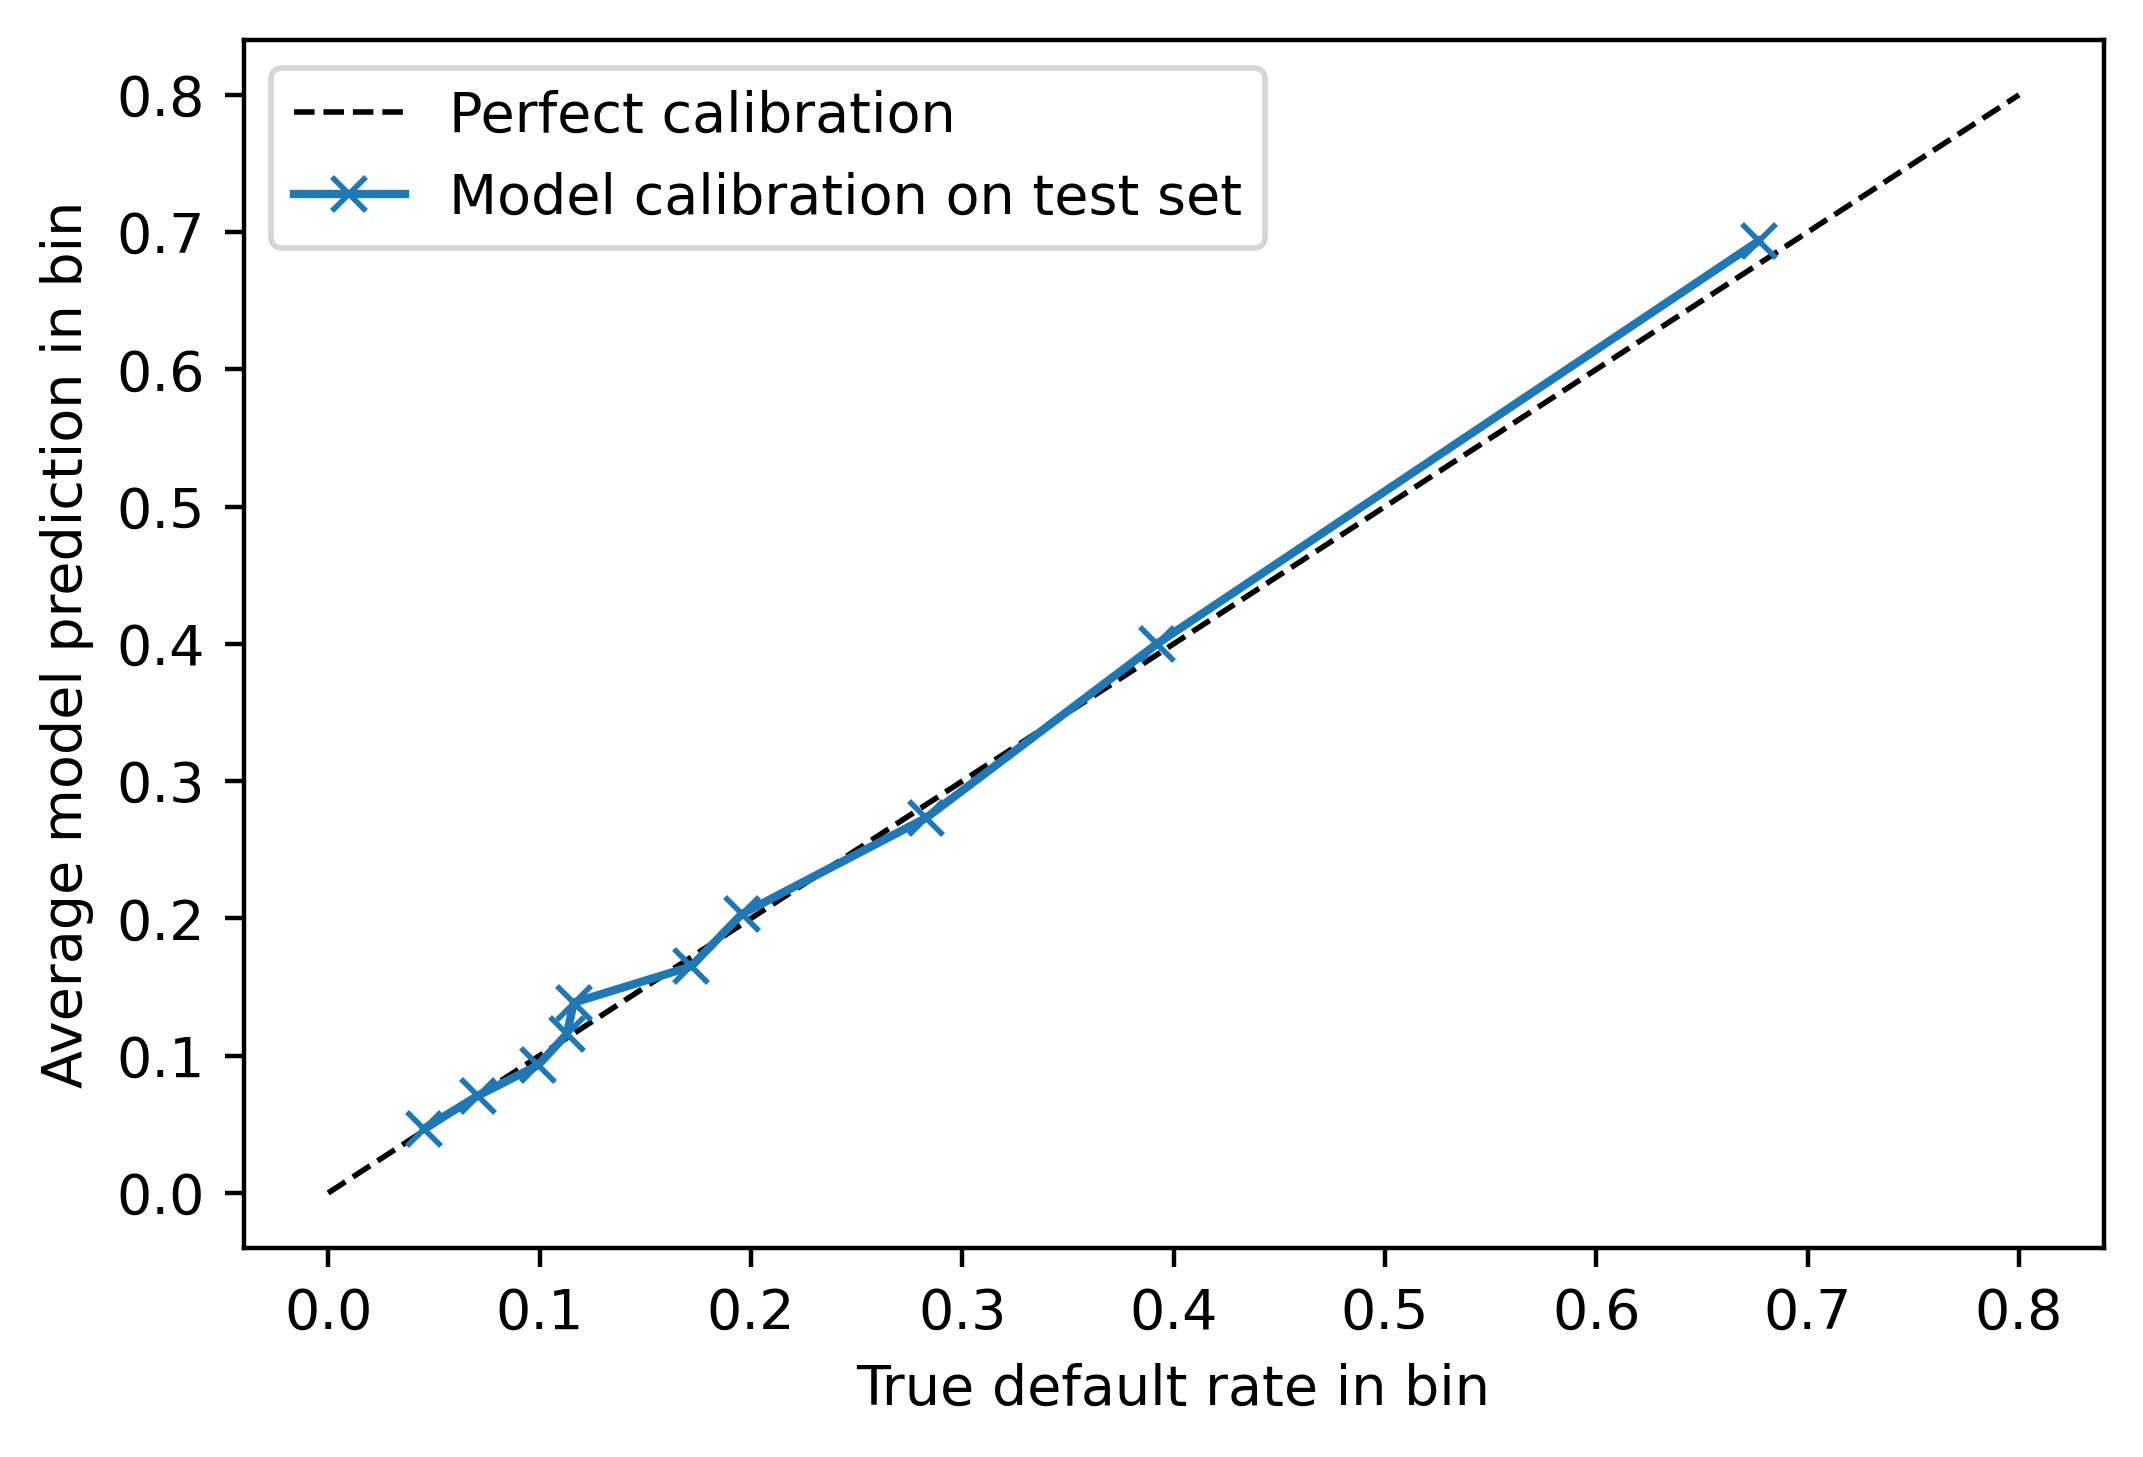

In [29]:
ax = plt.axes()
ax.plot([0, 0.8], [0, 0.8], 'k--', linewidth=1,
        label='Perfect calibration')
ax.plot(cal_df[('Outcome', 'mean')],
        cal_df[('Predicted probability', 'mean')],
        marker='x',
        label='Model calibration on test set')
ax.set_xlabel('True default rate in bin')
ax.set_ylabel('Average model prediction in bin')
ax.legend()

# Exercise 7.02: Characterizing Costs and Savings

In [30]:
thresholds = np.linspace(0, 1, 101)

In [31]:
features_response[5]

'BILL_AMT1'

In [32]:
cost_per_counseling = 7500

In [33]:
effectiveness = 0.70

In [34]:
n_pos_pred = np.empty_like(thresholds)
total_cost = np.empty_like(thresholds)
n_true_pos = np.empty_like(thresholds)
total_savings = np.empty_like(thresholds)
counter = 0
for threshold in thresholds:
    pos_pred = test_set_pred_proba > threshold
    n_pos_pred[counter] = sum(pos_pred)
    total_cost[counter] \
        = n_pos_pred[counter] * cost_per_counseling
    
    true_pos = pos_pred & y_test_all.astype(bool)
    n_true_pos[counter] = sum(true_pos)
    total_savings[counter] = np.sum(
        true_pos.astype(int)
        * X_test_all[:,5]
        * effectiveness
        )
    counter += 1

In [35]:
net_savings = total_savings - total_cost

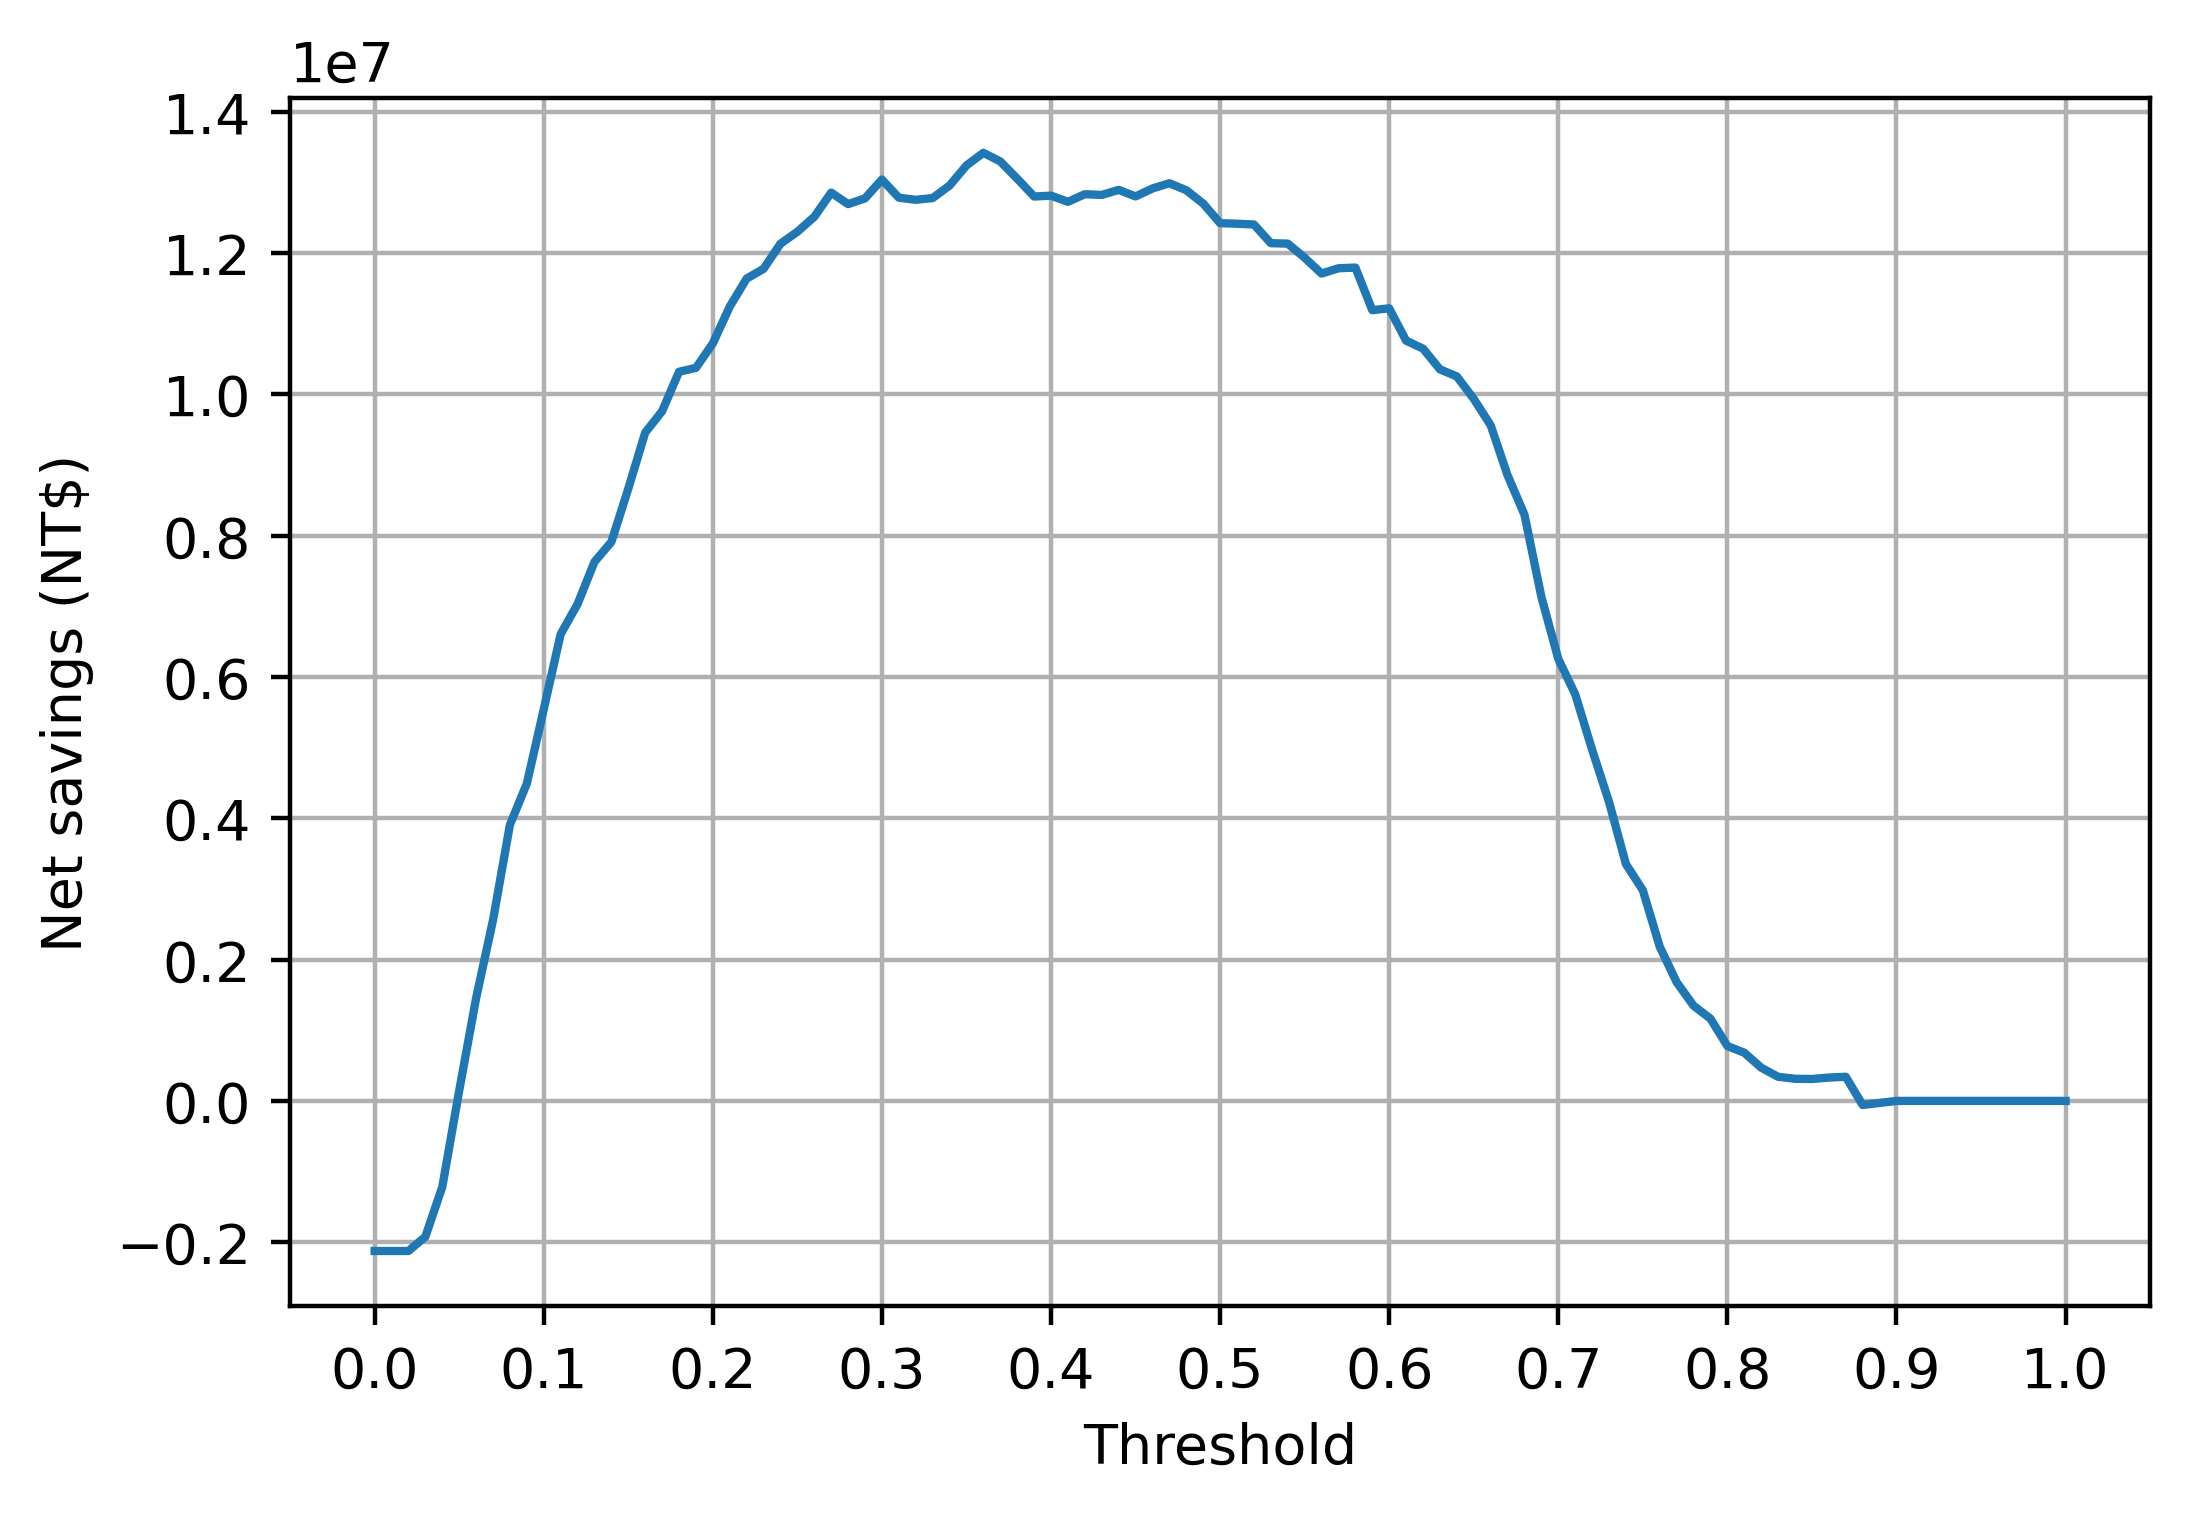

In [36]:
mpl.rcParams['figure.dpi'] = 400
plt.plot(thresholds, net_savings)
plt.xlabel('Threshold')
plt.ylabel('Net savings (NT$)')
plt.xticks(np.linspace(0,1,11))
plt.grid(True)

In [37]:
max_savings_ix = np.argmax(net_savings)

In [38]:
thresholds[max_savings_ix]
# 0.36

0.36

In [39]:
net_savings[max_savings_ix]
# 13415710.0

13415710.0

# Activity 7.01: Deriving Financial Insights

In [40]:
cost_of_defaults = np.sum(y_test_all * X_test_all[:,5])
cost_of_defaults
# 60587763.0

60587763.0

In [41]:
net_savings[max_savings_ix]/cost_of_defaults
# 0.2214260658542551

0.2214260658542551

In [42]:
net_savings[max_savings_ix]/len(y_test_all)
# 2259.2977433479286

2259.2977433479286

Text(0, 0.5, 'Net savings per account (NT$)')

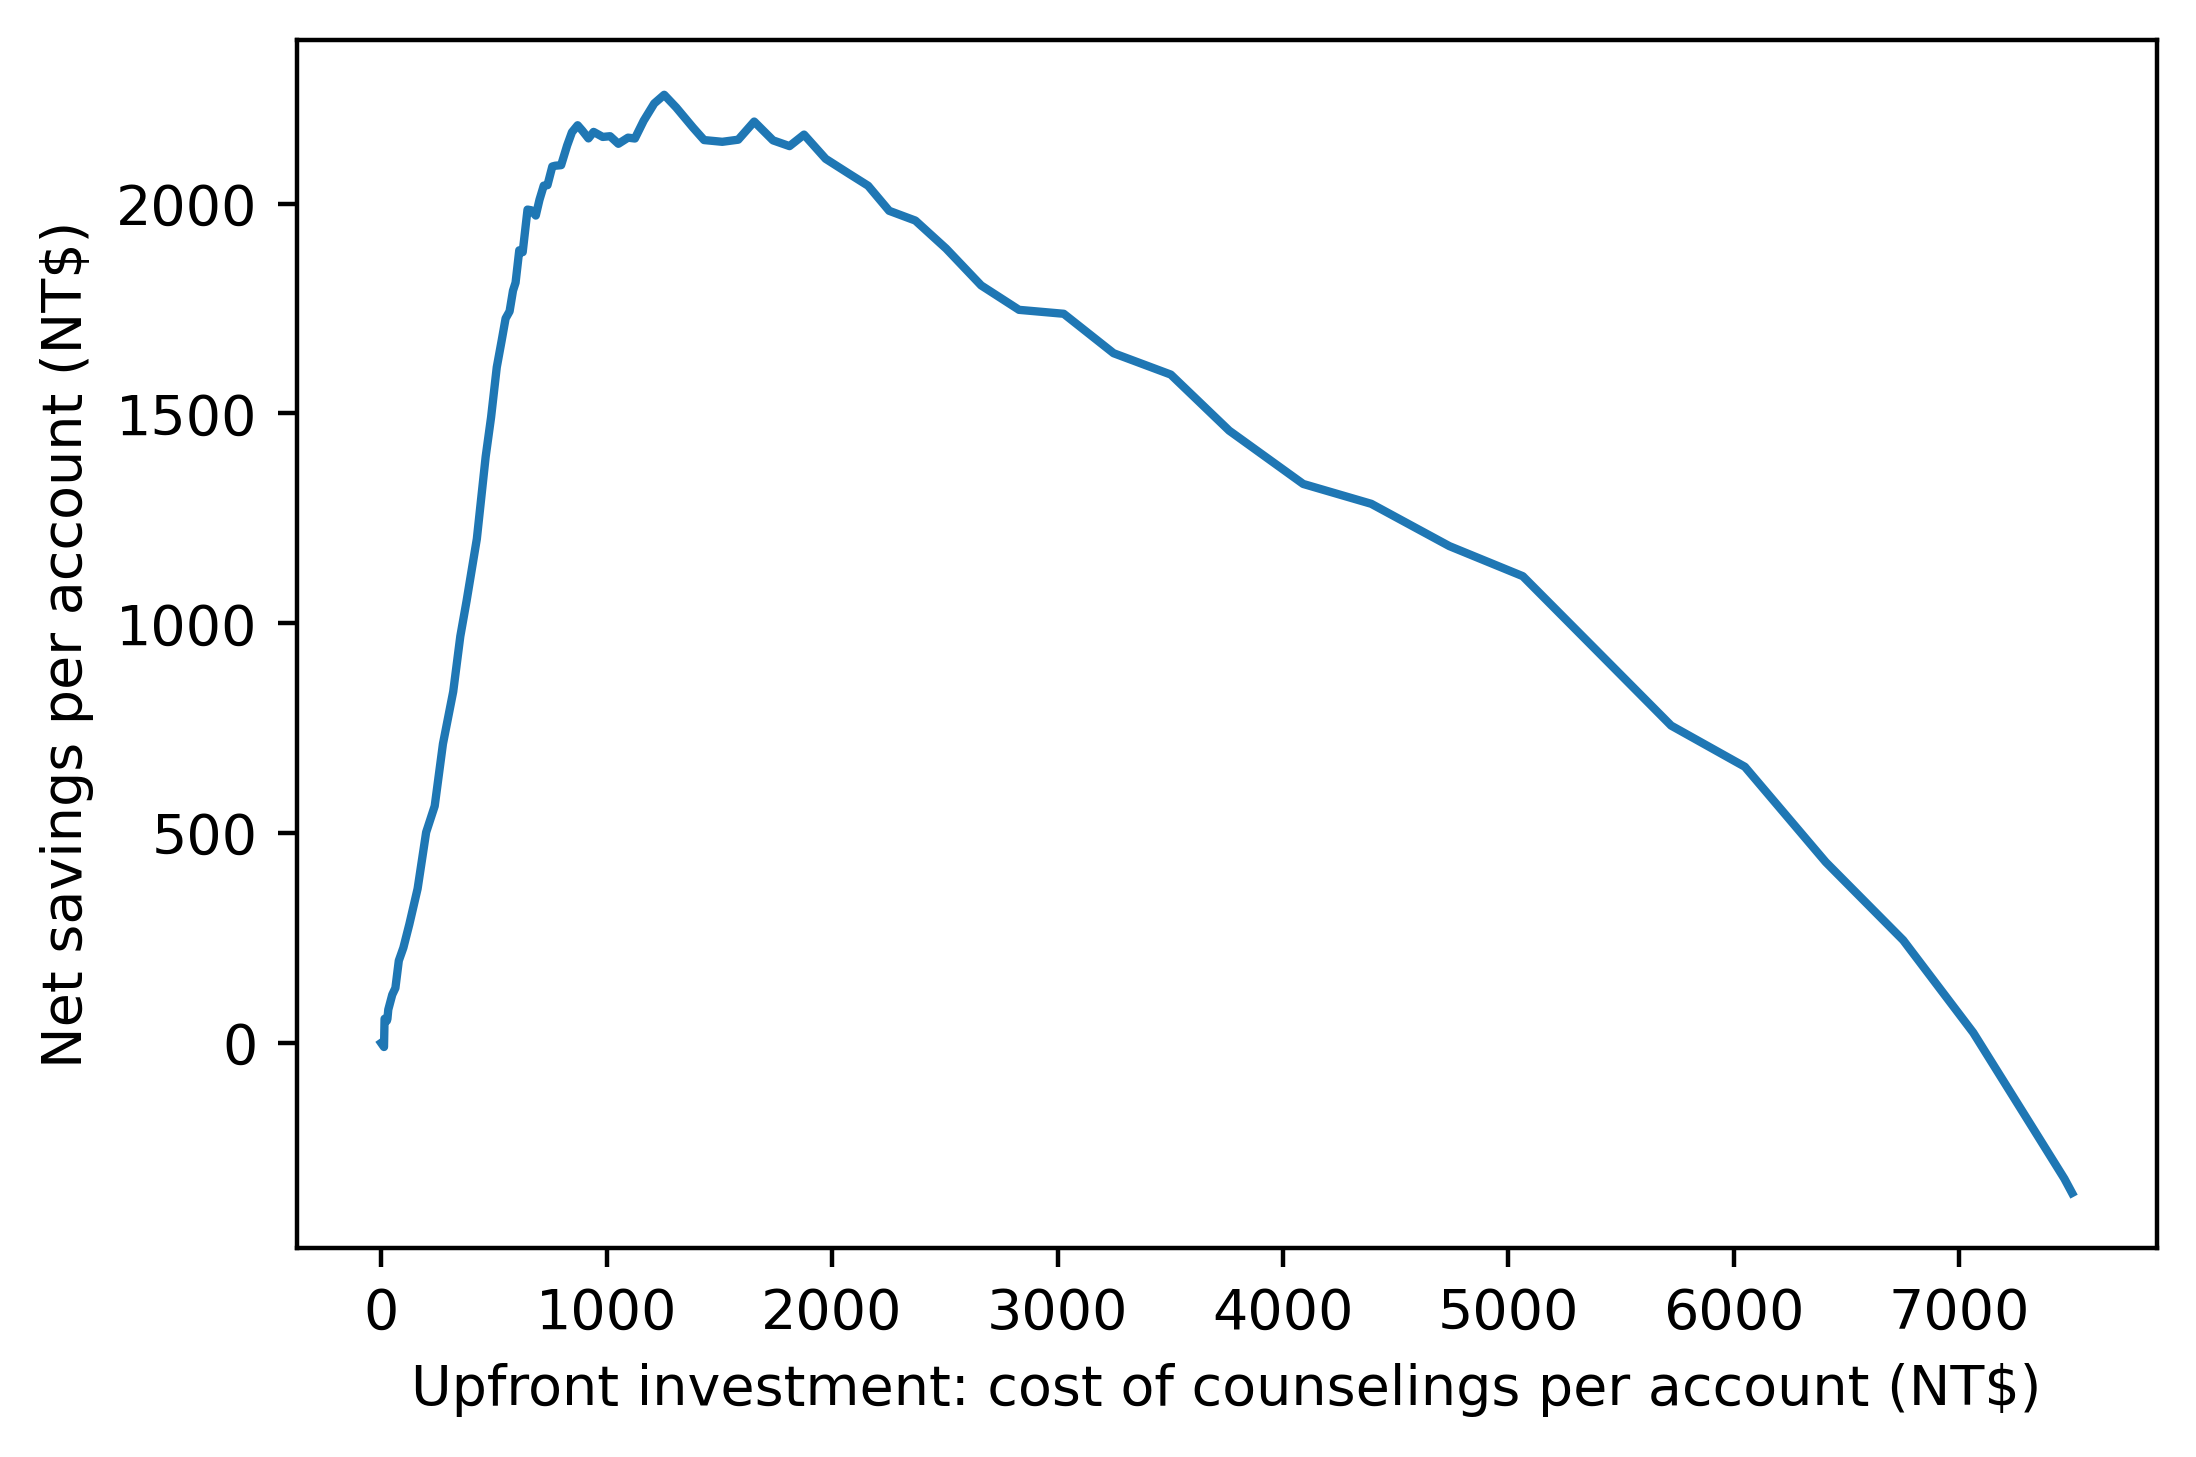

In [43]:
plt.plot(total_cost/len(y_test_all),
         net_savings/len(y_test_all))
plt.xlabel('Upfront investment: cost of counselings per account (NT$)')
plt.ylabel('Net savings per account (NT$)')

Text(0.5, 0, 'Threshold')

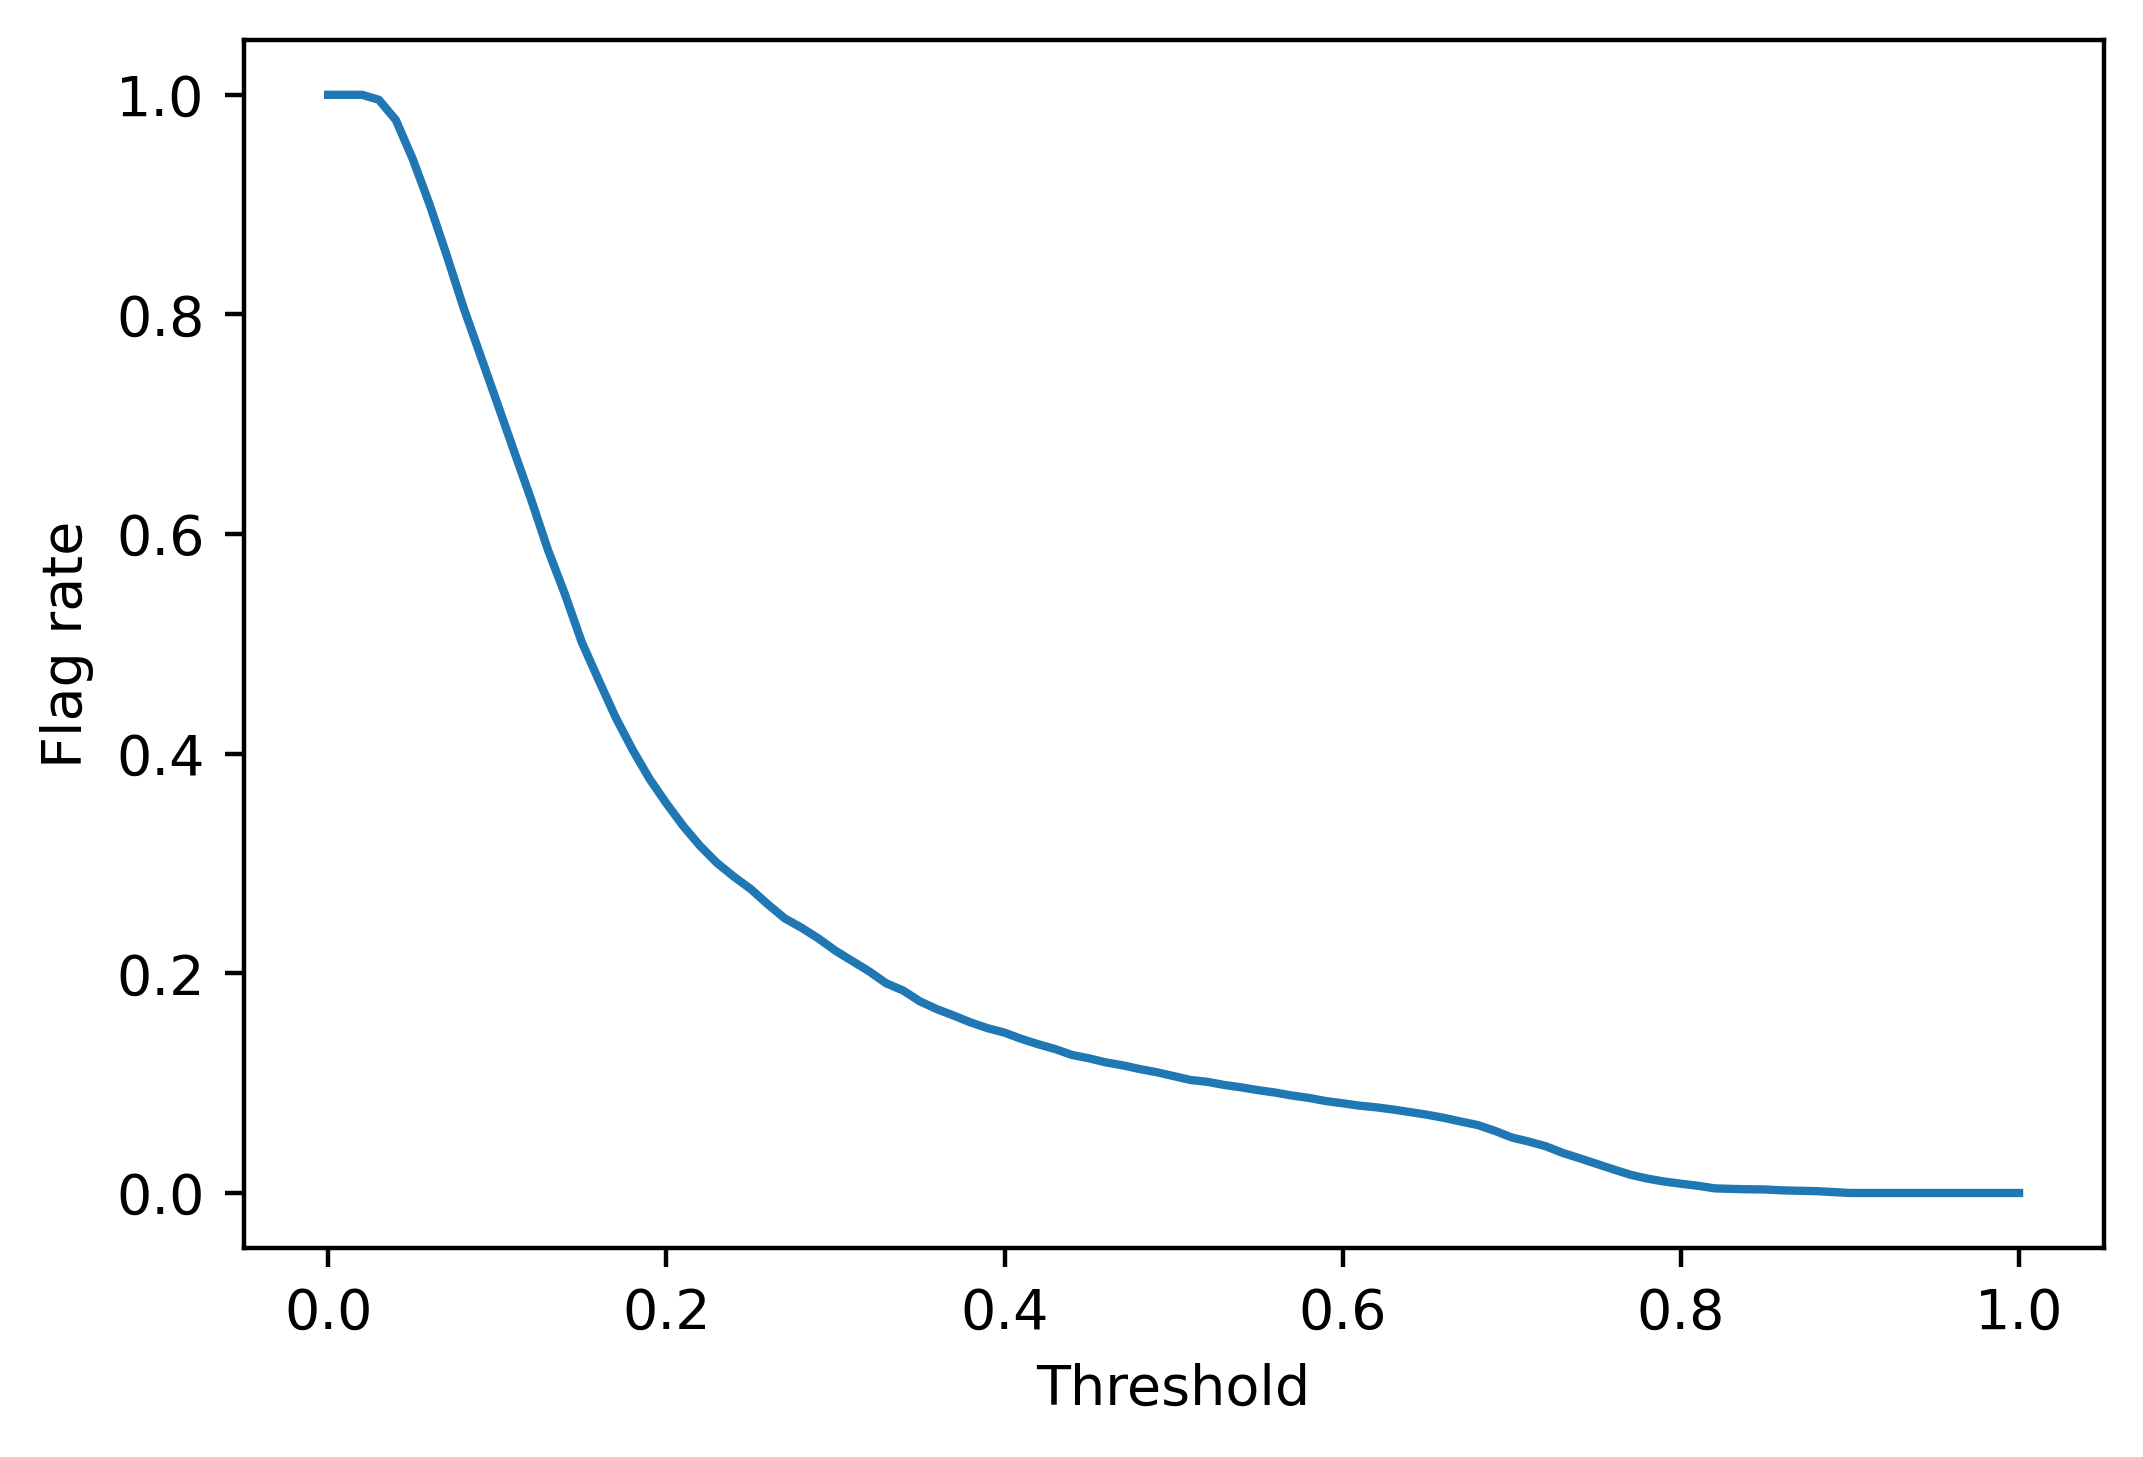

In [44]:
plt.plot(thresholds, n_pos_pred/len(y_test_all))
plt.ylabel('Flag rate')
plt.xlabel('Threshold')

invalid value encountered in true_divide


Text(0, 0.5, 'Precision')

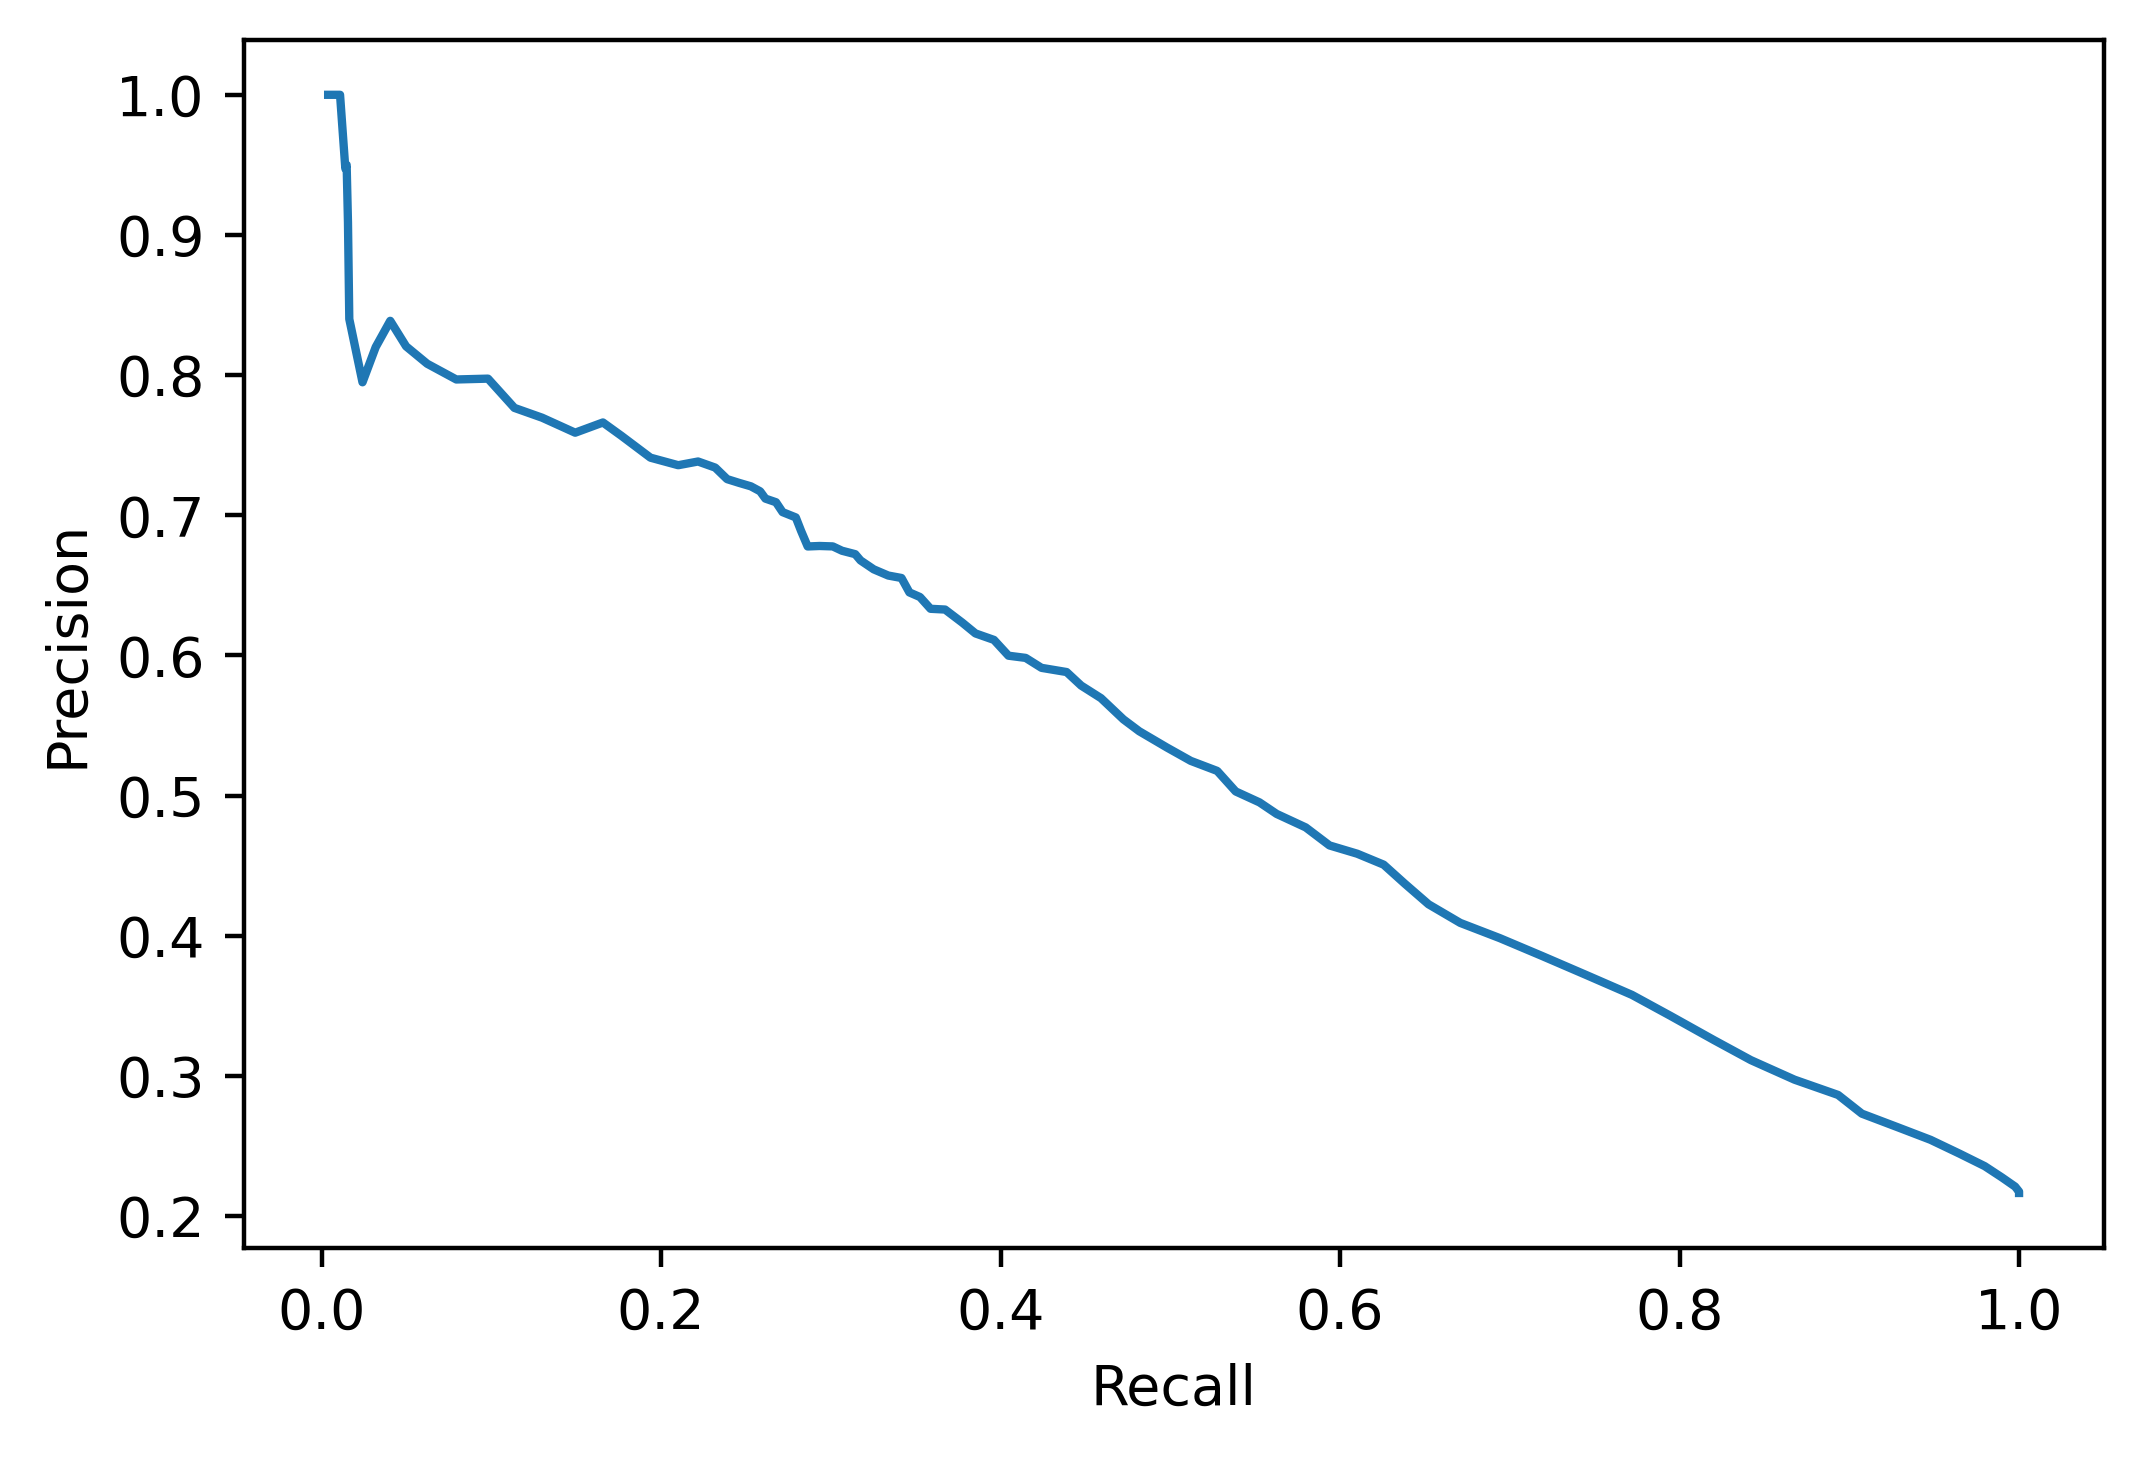

In [45]:
plt.plot(n_true_pos/sum(y_test_all),
         np.divide(n_true_pos, n_pos_pred))
plt.xlabel('Recall')
plt.ylabel('Precision')

invalid value encountered in true_divide


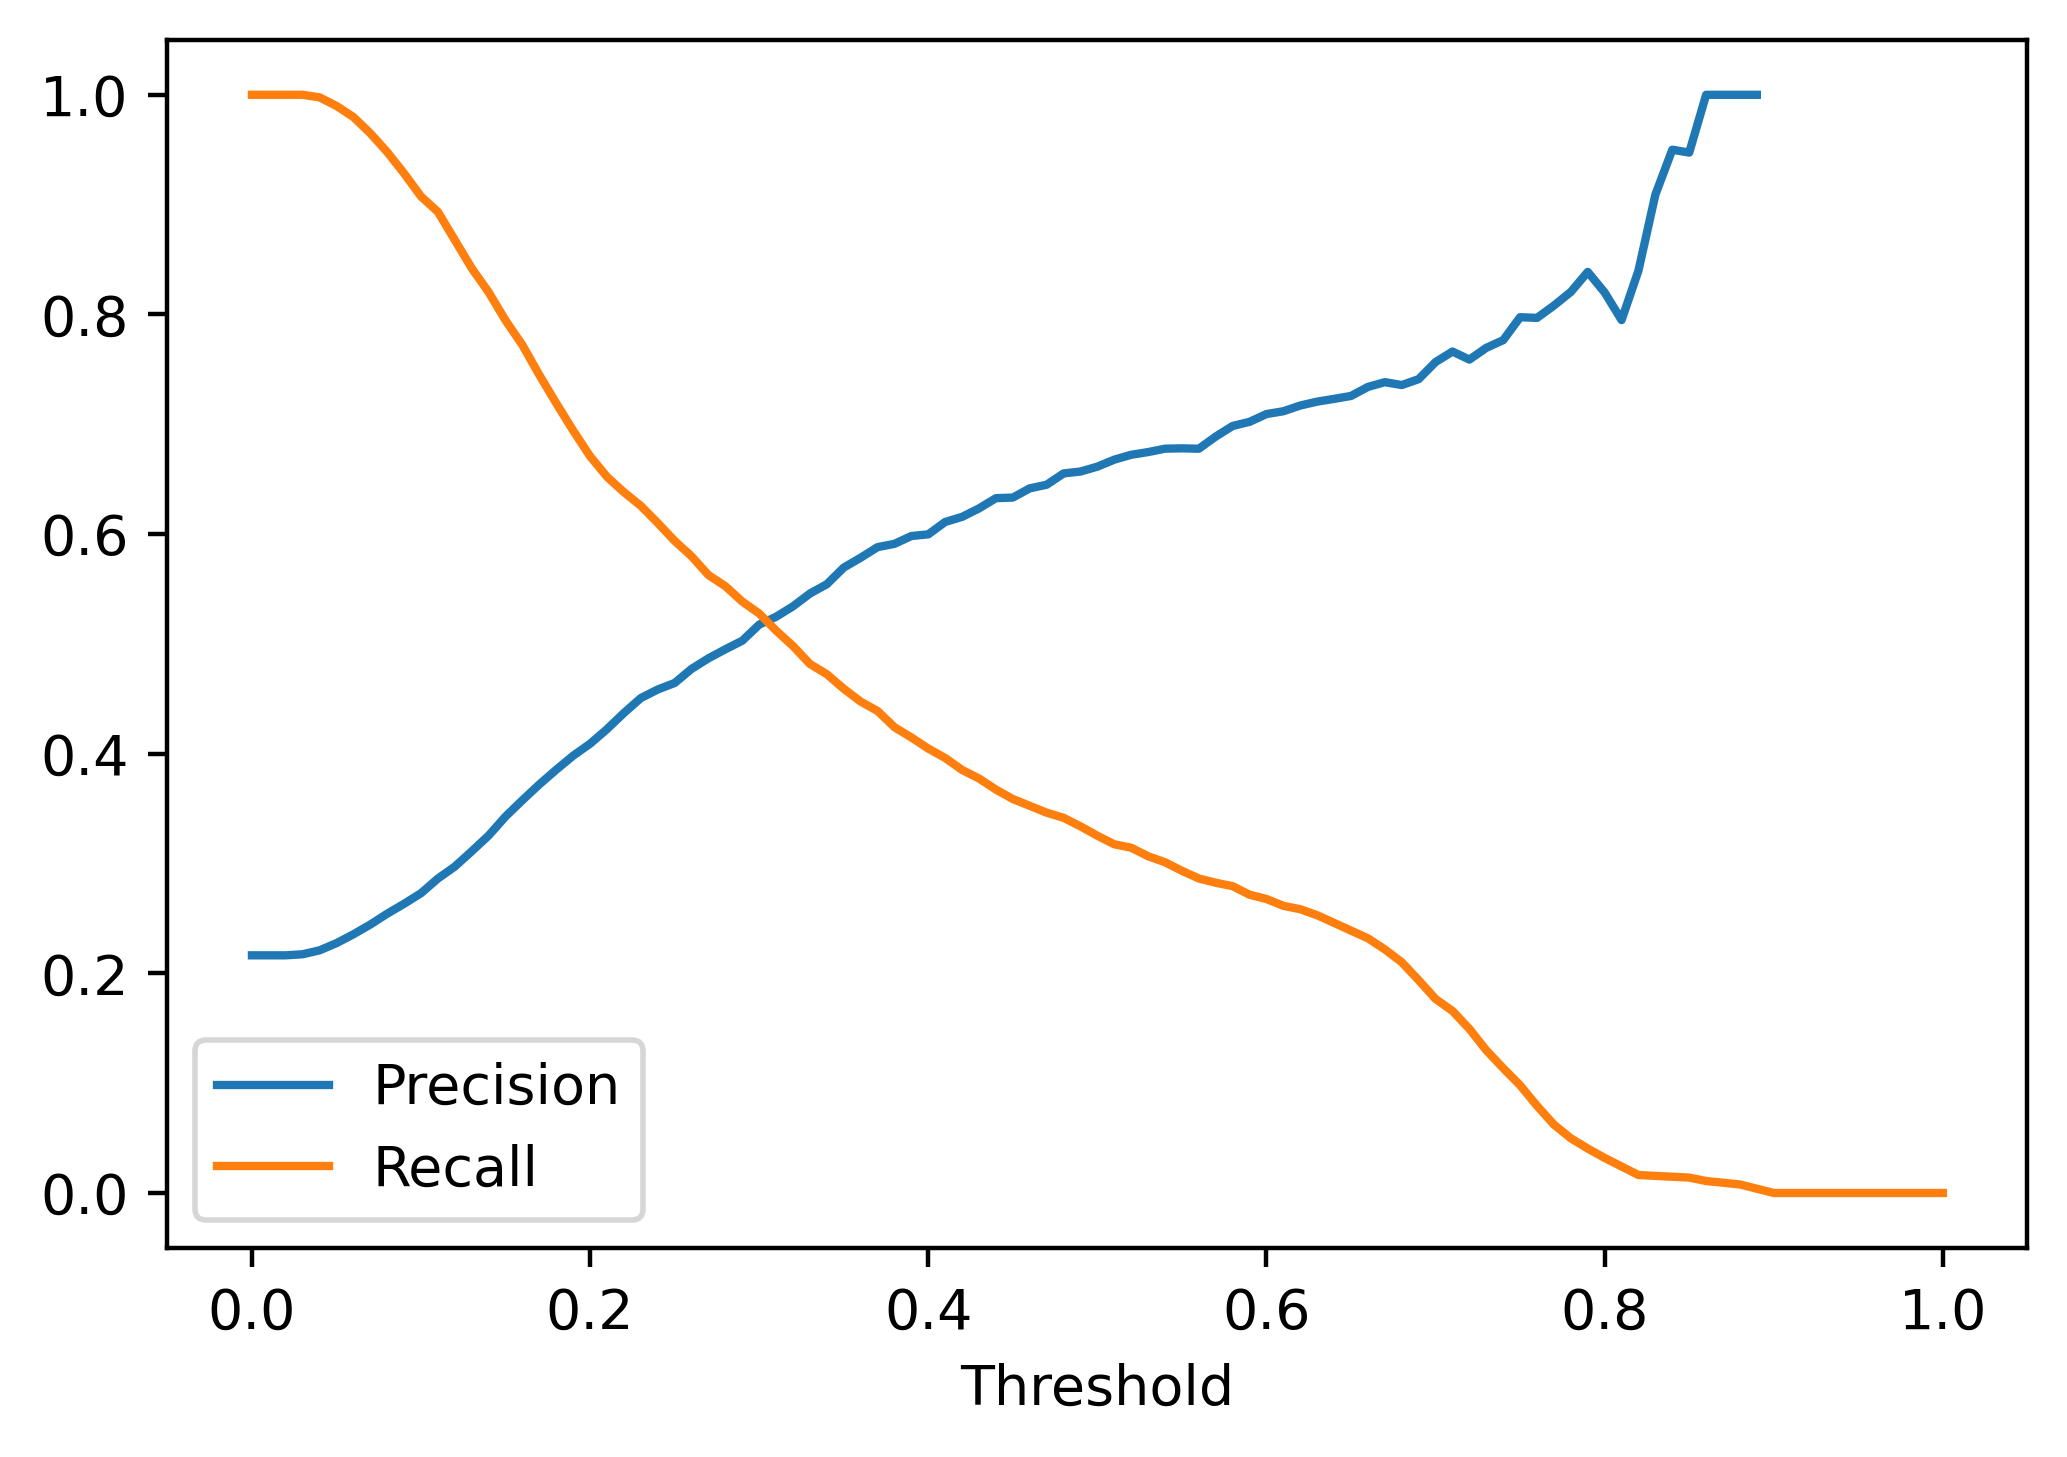

In [46]:
plt.plot(thresholds, np.divide(n_true_pos, n_pos_pred),
         label='Precision')
plt.plot(thresholds, n_true_pos/sum(y_test_all),
         label='Recall')
plt.xlabel('Threshold')
plt.legend()